In [1]:
import sys
import numpy as np

from PySDM.backends import CPU
from PySDM.builder import Builder
from PySDM.environments import Box
from PySDM.dynamics import Breakup
from PySDM.dynamics import Coalescence
from PySDM.initialisation.spectral_sampling import ConstantMultiplicity

from PySDM.products.state import ParticlesVolumeSpectrum, ParticlesConcentration, ParticleMeanRadius
from PySDM.products.stats.timers import WallTime

from matplotlib import pyplot

from PySDM.initialisation.spectra import Exponential
from PySDM.physics.collision_kernels import Golovin, Geometric
from PySDM.physics.coalescence_efficiencies import Berry1967, ConstEc
from PySDM.physics.breakup_fragmentations import AlwaysN, SLAMS
from PySDM.physics.constants import si
from PySDM.physics.formulae import Formulae
from pystrict import strict

from numba import config, threading_layer
config.THREADING_LAYER = 'threadsafe'

In [2]:
@strict
class Settings:

    def __init__(self):
        self.formulae = Formulae()
        self.n_sd = 2**3
        self.n_part = 100 / si.cm**3
        self.X0 = self.formulae.trivia.volume(radius=30.531 * si.micrometres)
        self.dv = 1 * si.m**3
        self.norm_factor = self.n_part * self.dv
        self.rho = 1000 * si.kilogram / si.metre**3
        self.dt = 1 * si.seconds
        self.adaptive = False
        #self.seed = 123
        self._steps = [0, 1, 2]
        self.kernel = Golovin(b=15000 / si.second)
        self.coal_eff = ConstEc(0.5)     # no collisions
        self.fragmentation = AlwaysN(n=3)
        self.spectrum = Exponential(norm_factor=self.norm_factor, scale=self.X0)
        self.radius_bins_edges = np.logspace(np.log10(10 * si.um), np.log10(100 * si.um), num=128, endpoint=True)
        self.radius_range = [0 * si.um, 1e6 * si.um]

    @property
    def output_steps(self):
        return [int(step/self.dt) for step in self._steps]

Breakup:  [0.72494507 0.42211629 0.20927009 0.99279002] [0.04649643 0.2325637  0.54265387 0.42384967]
Coalescence2:  [0.98272615 0.70588099 0.9127565  0.80329003]
Breakup:  [0.62750313 0.30065728 0.10809011 0.89233132] [0.59366984 0.07106384 0.86394502 0.59808471]
Coalescence2:  [0.97380555 0.42019598 0.07968988 0.95591425]


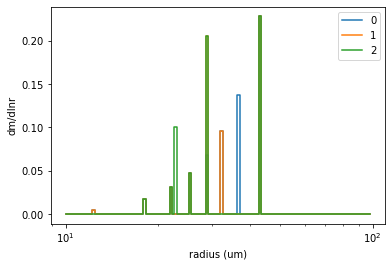

In [6]:
settings = Settings()
backend = CPU

builder = Builder(n_sd=settings.n_sd, backend=backend, formulae=settings.formulae)
builder.set_environment(Box(dv=settings.dv, dt=settings.dt))
attributes = {}
attributes['volume'], attributes['n'] = ConstantMultiplicity(settings.spectrum).sample(settings.n_sd)
breakup = Breakup(settings.kernel, settings.coal_eff, settings.fragmentation, adaptive=settings.adaptive)
builder.add_dynamic(breakup)
coalescence = Coalescence(settings.kernel, settings.coal_eff, adaptive=settings.adaptive)
builder.add_dynamic(coalescence)
products = [ParticlesVolumeSpectrum(), WallTime(), ParticleMeanRadius(), ParticlesConcentration(radius_range = settings.radius_range)]
core = builder.build(attributes, products)

for step in settings.output_steps:
    core.run(step - core.n_steps)
    pyplot.step(x=settings.radius_bins_edges[:-1] / si.micrometres, 
                y=core.products['dv/dlnr'].get(settings.radius_bins_edges) * settings.rho,
                where='post', label="t = {step*settings.dt}s")
    #print(core.products['radius_m1'].get(), core.products['n_a_cm3'].get())
    
pyplot.xscale("log")
pyplot.xlabel("radius (um)")
pyplot.ylabel("dm/dlnr")
pyplot.legend([0, 1, 2])

In [4]:
Breakup:  [0.45266617 0.96601    0.40920068 0.1849399 ] [0.10989256 0.70900989 0.36081917 0.7977644 ]
Coalescence2:  [0.20888366 0.6639128  0.54132028 0.39876931]
Breakup:  [0.17049458 0.53626019 0.64991945 0.40314732] [0.21535997 0.74911539 0.99756181 0.41574785]
Coalescence2:  [0.37014397 0.70525876 0.23692592 0.74450201]

SyntaxError: invalid syntax (<ipython-input-4-8b13b6999d79>, line 1)

In [ ]:
Breakup:  [0.49596368 0.79420218 0.43196597 0.22505372] [0.56433569 0.41152345 0.18602426 0.66396069]
Coalescence2:  [0.24962726 0.53297109 0.69754421 0.37390169]
Breakup:  [0.61200657 0.39072841 0.20248416 0.53744049] [0.32690274 0.29528573 0.10817429 0.02436145]
Coalescence2:  [0.06279447 0.96298934 0.16355822 0.22628348]